In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, "..")
from src.wdscan import select_roi
from fitting_helper_funs import (
    simulate_spectra_montecarlo
    , fit_baseline_and_plot
    , fit_mc_bg
    , plot_mc_bg_fits
    , fit_multiple_gaussians
    , fit_multiple_gaussians_mc
)


In [6]:
lab = "ANU"
xtl = "LDE1H"
s = "Buddingtonite"

data = pd.read_csv(f'../data/processed/peak_shapes/data_with_fits_{lab}/{xtl}/{s}.csv', index_col=0)

data

,L,cps,cps_per_nA,cps_per_nA_stdev,baseline,cps_per_nA_corrected,fit
0,125.0,37.111111,3.711971,1.621366,4.344708,-0.632738,0.000034
1,125.1,45.000000,4.500992,1.775071,4.301043,0.199949,0.000037
2,125.2,41.333333,4.134234,1.893020,4.258082,-0.123848,0.000041
3,125.3,39.777778,3.978695,1.414265,4.215810,-0.237115,0.000045
4,125.4,40.111111,4.012039,1.589760,4.174212,-0.162172,0.000050
...,...,...,...,...,...,...,...
396,164.6,6.000000,0.600140,0.567112,0.709210,-0.109070,0.000676
397,164.7,5.111111,0.511232,0.492546,0.707815,-0.196582,0.000624
398,164.8,6.777778,0.677957,0.590089,0.706426,-0.028470,0.000576
399,164.9,6.222222,0.622367,0.687207,0.705046,-0.082679,0.000532


# Create a figure demonstrating the fit method

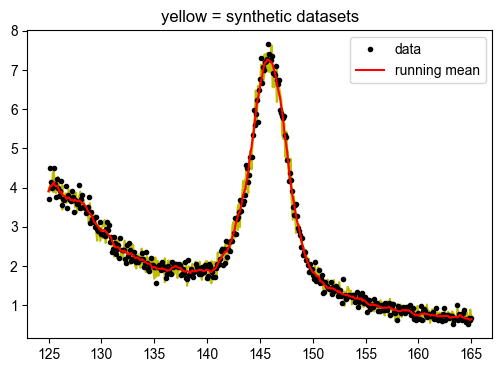

In [7]:
synthetic_data = simulate_spectra_montecarlo(
    data,
    window_size=9,
    number_of_mc_simulations=2, 
    plot=True
    )

Fitting montecarlo simulation 1 of 2


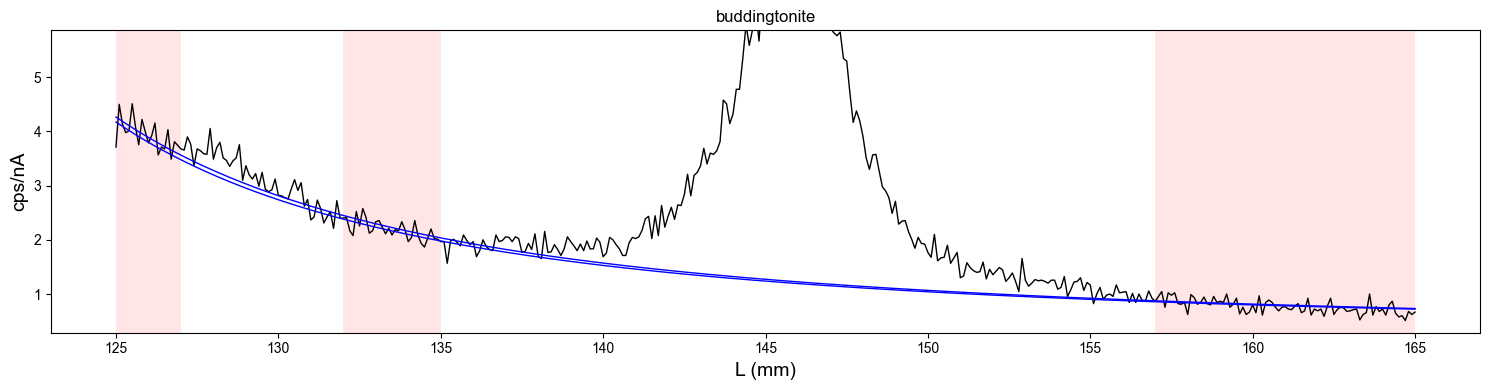

In [8]:
roi = np.array([[125,127], [132, 135], [157,165]])
baselines, corrected_data = fit_mc_bg(
    synthetic_data
    , roi
    , bg_type='lorentzian_plus_c', randomise_roi=True)
            
plot_mc_bg_fits(
    data
    , synthetic_data
    , baselines
    , roi
    , sample="buddingtonite")


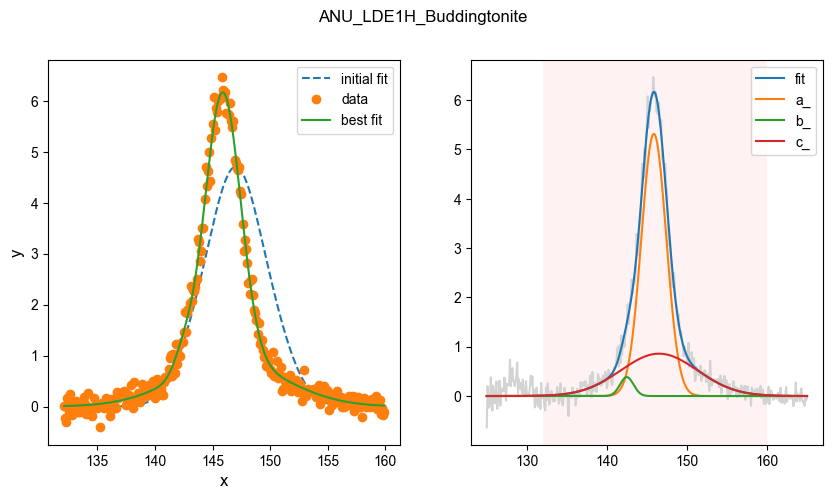

In [10]:
s = 'Buddingtonite'

lab = 'ANU'
rois = {'LDE1': [[132, 160]],
         'LDE1H': [[132, 160]]}
  
roi = rois[xtl]
df = select_roi(data, roi)
ymax = df.cps_per_nA_corrected.max()

pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
            {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
              {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
        ]

fit_dict = fit_multiple_gaussians(data, pk_params,
                                                y_column='cps_per_nA_corrected',
                                                roi=roi,
                                                samplename='_'.join([lab, xtl, s]),
                                                plot=True, plot_only_roi=False)


Fitting montecarlo simulation 1 of 3


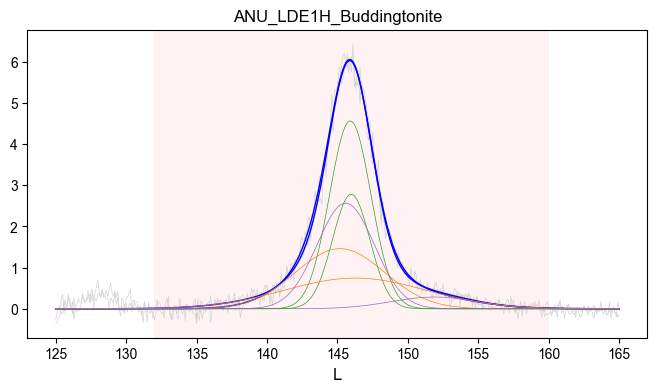

In [12]:
lab = 'ANU'
s = 'Buddingtonite'

rois = {'LDE1': [[132, 160]],
         'LDE1H': [[132, 160]]}

roi = rois[xtl]
df = select_roi(data, roi)
ymax = df.cps_per_nA_corrected.max()

pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
            {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
              {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2}
        ]

mc_fit_dict = fit_multiple_gaussians_mc(corrected_data, pk_params,
    roi=roi, samplename='_'.join([lab, xtl, s]))

In [13]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

plt.rcParams['font.family'] = 'arial'

In [ ]:
df = data[lab][xtl][s]
df_mc = synthetic_data[lab][xtl][s]
df_mc_corr = corrected_data[lab][xtl][s]

fit_mc_corr = mc_fit_dict[lab][xtl][s]

fig, axs = plt.subplots(3, 1, figsize = (8*0.39, 17*0.39), sharex=True)
axs = axs.ravel()

axs[0].set_title('Original data & simulations', fontsize=10)
color_list = ["tab:blue", "tab:orange"]
axs[0].plot(df.L, df.cps_per_nA, '-k', lw=0.5, label="Original", zorder=99)
for col in df_mc.columns[:2]:
    axs[0].plot(df_mc.index, df_mc[col], lw=0.5, color=color_list[col], label="Simulated")
axs[0].legend(fontsize=8, loc="upper right")

axs[1].set_title('Fitting the background', fontsize=10)
axs[1].plot(df.L, df.cps_per_nA, '-k', lw=0.5)
axs[1].plot(df.L, df.baseline, '-r', lw=2)

axs[2].set_title('Fitting the peak', fontsize=10)
axs[2].plot(df.L, df.cps_per_nA_corrected, '-k', lw=0.5)
axs[2].plot(df.L, df.fit, '-r', lw=2)

# axs[3].set_title('Background-corrected simulations', fontsize=10)
# for col in df_mc.columns[:2]:
#     # plot the data
#     axs[3].plot(df_mc_corr.index, df_mc_corr[col], lw=0.5, color=color_list[col])
#     # plot the fits
#     fitted_curve = fit_mc_corr[col].eval(x=df_mc_corr.index)
#     axs[3].plot(df_mc_corr.index, fitted_curve, label='fit', color=)

for ax in axs:
    ax.set_ylabel('cps/nA')
    ax.set_xlim([125, 165])
    
axs[2].set_xlabel('Spectrometer position, L (mm)')

alphalabel = 'ABCD'
for i, ax in enumerate(axs):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, alphalabel[i], transform=ax.transAxes + trans,
            fontsize=12, verticalalignment='top', fontfamily='Arial',
            bbox=dict(facecolor='w', edgecolor='grey', pad=3.0))

plt.tight_layout()

plt.savefig('../figures/figure_fit_method.png')
plt.savefig('../figures/for_submission/Figure_7.pdf', dpi=600)

In [16]:
data

,L,cps,cps_per_nA,cps_per_nA_stdev,baseline,cps_per_nA_corrected,fit
0,125.0,37.111111,3.711971,1.621366,4.344708,-0.632738,0.000034
1,125.1,45.000000,4.500992,1.775071,4.301043,0.199949,0.000037
2,125.2,41.333333,4.134234,1.893020,4.258082,-0.123848,0.000041
3,125.3,39.777778,3.978695,1.414265,4.215810,-0.237115,0.000045
4,125.4,40.111111,4.012039,1.589760,4.174212,-0.162172,0.000050
...,...,...,...,...,...,...,...
396,164.6,6.000000,0.600140,0.567112,0.709210,-0.109070,0.000676
397,164.7,5.111111,0.511232,0.492546,0.707815,-0.196582,0.000624
398,164.8,6.777778,0.677957,0.590089,0.706426,-0.028470,0.000576
399,164.9,6.222222,0.622367,0.687207,0.705046,-0.082679,0.000532


In [17]:
synthetic_data

,0,1
L,,
125.0,3.904520,3.904520
125.1,3.900903,4.028100
125.2,3.987352,4.100909
125.3,3.962576,4.112028
125.4,4.377634,3.898405
...,...,...
164.6,0.803907,0.700199
164.7,0.634686,0.627361
164.8,0.534693,0.635922


In [18]:
corrected_data

,0,1
L,,
125.0,-0.362379,-0.269737
125.1,-0.325635,-0.106087
125.2,-0.199439,0.006172
125.3,-0.185070,0.056132
125.4,0.268544,-0.119245
...,...,...
164.6,0.065561,-0.026330
164.7,-0.102209,-0.097782
164.8,-0.200758,-0.087842


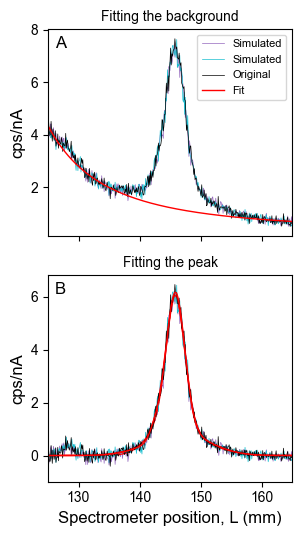

In [39]:
df = data
df_mc = synthetic_data
df_mc_corr = corrected_data
fit_mc_corr = mc_fit_dict

fig, axs = plt.subplots(2, 1, figsize = (8*0.39, 14*0.39), sharex=True)
axs = axs.ravel()

# axs[0].set_title('Original data & simulations', fontsize=10)
axs[0].set_title('Fitting the background', fontsize=10)

color_list = ["tab:purple", "tab:cyan"]
for col in df_mc.columns[:2]:
    axs[0].plot(df_mc.index, df_mc[col], lw=0.5, color=color_list[col], label="Simulated")
axs[0].plot(df.L, df.cps_per_nA, '-k', lw=0.5, label="Original")
axs[0].plot(df.L, df.baseline, '-r', lw=1, label="Fit")
axs[0].legend(fontsize=8, loc="upper right")

axs[1].set_title('Fitting the peak', fontsize=10)
for col in df_mc.columns[:2]:
    # plot the data
    axs[1].plot(df_mc_corr.index, df_mc_corr[col], lw=0.5, color=color_list[col])
    # plot the fits
    fitted_curve = fit_mc_corr[col].eval(x=df_mc_corr.index)
    axs[1].plot(df_mc_corr.index, fitted_curve, label='fit', color="red", lw=1)

axs[1].plot(df.L, df.cps_per_nA_corrected, '-k', lw=0.5)
axs[1].plot(df.L, df.fit, '-r', lw=1)

for ax in axs:
    ax.set_ylabel('cps/nA')
    ax.set_xlim([125, 165])
    
axs[1].set_xlabel('Spectrometer position, L (mm)')

alphalabel = 'ABCD'
for i, ax in enumerate(axs):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, alphalabel[i], transform=ax.transAxes + trans,
            fontsize=12, verticalalignment='top', fontfamily='Arial',
            # bbox=dict(facecolor='w', edgecolor='grey', pad=3.0)
            )

plt.tight_layout()

plt.savefig('../figures/figure_fit_method.png')
plt.savefig('../figures/for_submission/Figure_7.pdf', dpi=600)